# Land Cover Classification Model Evaluation

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pathlib import Path
import json

In [7]:
model = tf.keras.models.load_model('../models/model_rgb.h5')
print(f'model loaded: {model.input_shape} -> {model.output_shape}')

model loaded: (None, 64, 64, 3) -> (None, 9)


In [ ]:
class_names = ['bare_sparse', 'built-up', 'cropland', 'grassland', 'mangroves', 'shrubland', 'trees', 'water', 'wetland']
img_size = 64

In [15]:
test_data_path = Path('../data/demo_training_data')
test_images = []
test_labels = []

for idx, class_name in enumerate(class_names):
    class_path = test_data_path / class_name
    if class_path.exists():
        image_files = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg'))
        for img_path in image_files[:50]:
            img = tf.keras.utils.load_img(img_path, target_size=(img_size, img_size))
            img_array = tf.keras.utils.img_to_array(img) / 255.0
            test_images.append(img_array)
            test_labels.append(idx)

test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(f'loaded {len(test_images)} test images')

loaded 160 test images


In [16]:
predictions = model.predict(test_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

## Overall Metrics

In [17]:
accuracy = accuracy_score(test_labels, predicted_classes)
print(f'overall accuracy: {accuracy:.4f}')

overall accuracy: 0.7500


In [19]:
print(classification_report(test_labels, predicted_classes, target_names=class_names, labels=list(range(len(class_names))), digits=4))

              precision    recall  f1-score   support

 bare_sparse     1.0000    1.0000    1.0000        20
    built_up     0.0000    0.0000    0.0000         0
    cropland     1.0000    1.0000    1.0000        20
   grassland     1.0000    1.0000    1.0000        20
   mangroves     0.0000    0.0000    0.0000        20
   shrubland     1.0000    1.0000    1.0000        20
       trees     1.0000    1.0000    1.0000        20
       water     0.5000    1.0000    0.6667        20
     wetland     0.0000    0.0000    0.0000        20

    accuracy                         0.7500       160
   macro avg     0.6111    0.6667    0.6296       160
weighted avg     0.6875    0.7500    0.7083       160



C:\Users\user\PycharmProjects\ml-deployment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\ml-deployment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\ml-deployment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

## Confusion Matrix

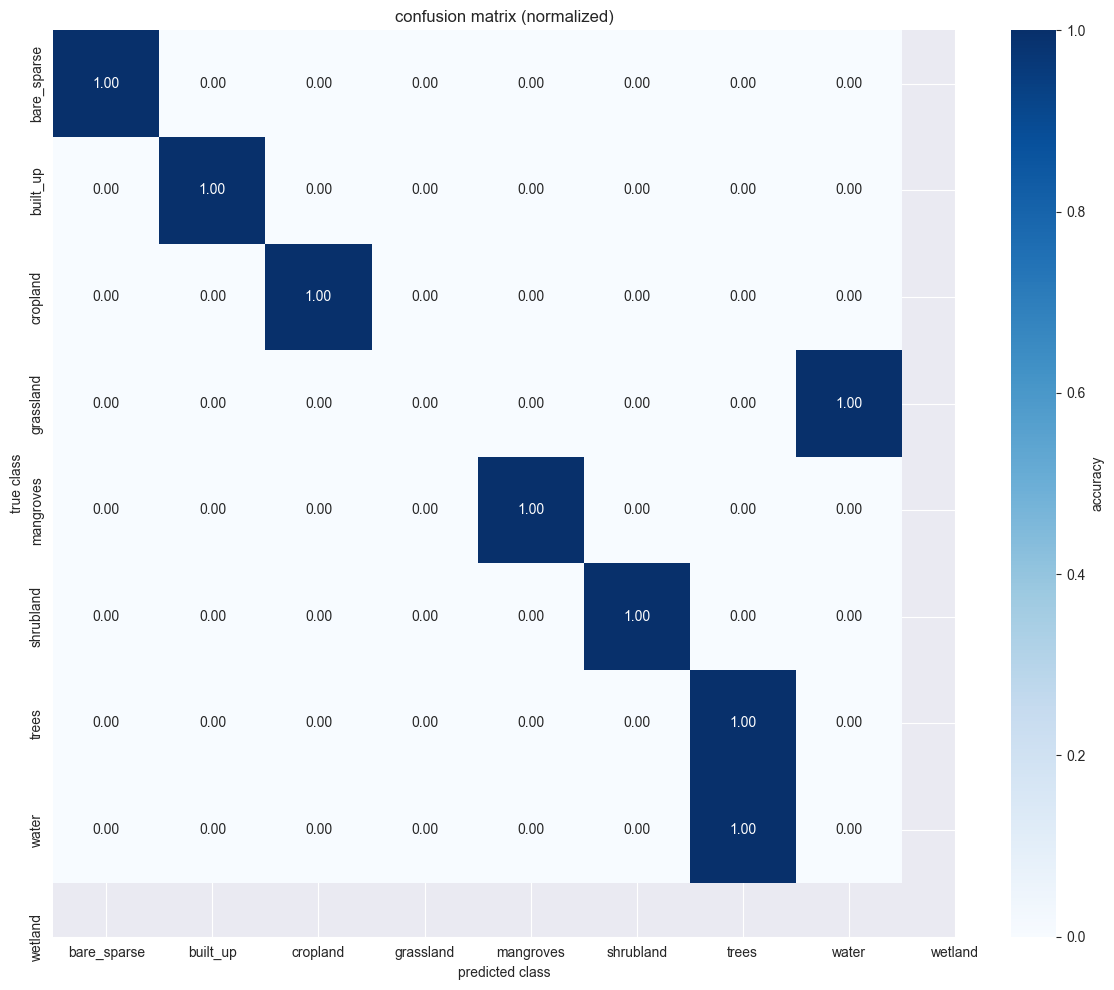

In [20]:
cm = confusion_matrix(test_labels, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'accuracy'})
plt.title('confusion matrix (normalized)')
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.show()

## Class-wise Performance

In [21]:
class_accuracies = cm_normalized.diagonal()
class_performance = list(zip(class_names, class_accuracies))
class_performance.sort(key=lambda x: x[1], reverse=True)

for class_name, acc in class_performance:
    print(f'{class_name:15} {acc:.4f}')

bare_sparse     1.0000
built_up        1.0000
cropland        1.0000
mangroves       1.0000
shrubland       1.0000
trees           1.0000
grassland       0.0000
water           0.0000


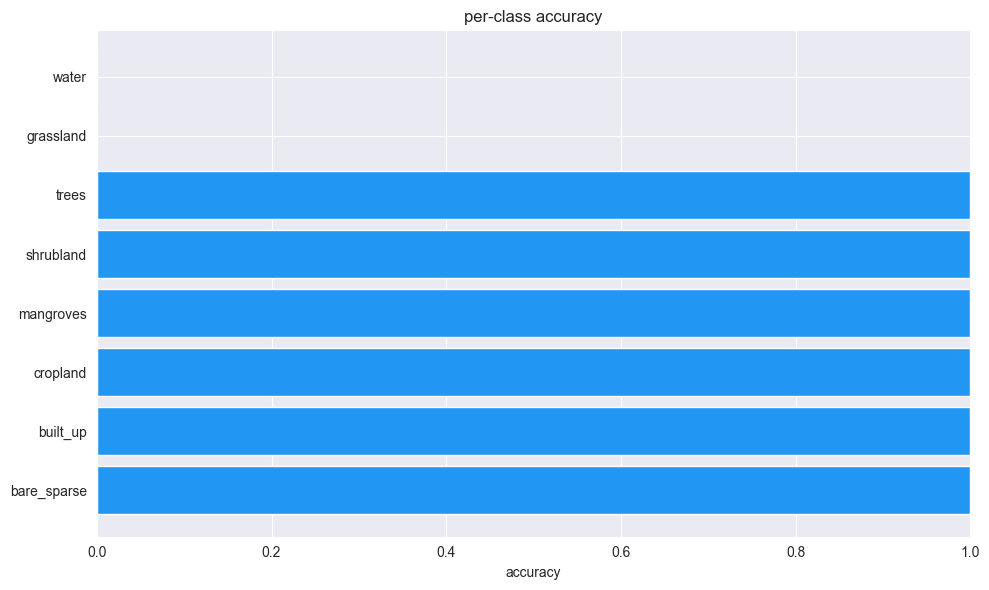

In [22]:
plt.figure(figsize=(10, 6))
plt.barh([name for name, _ in class_performance], [acc for _, acc in class_performance], color='#2196f3')
plt.xlabel('accuracy')
plt.title('per-class accuracy')
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

## Confidence Distribution

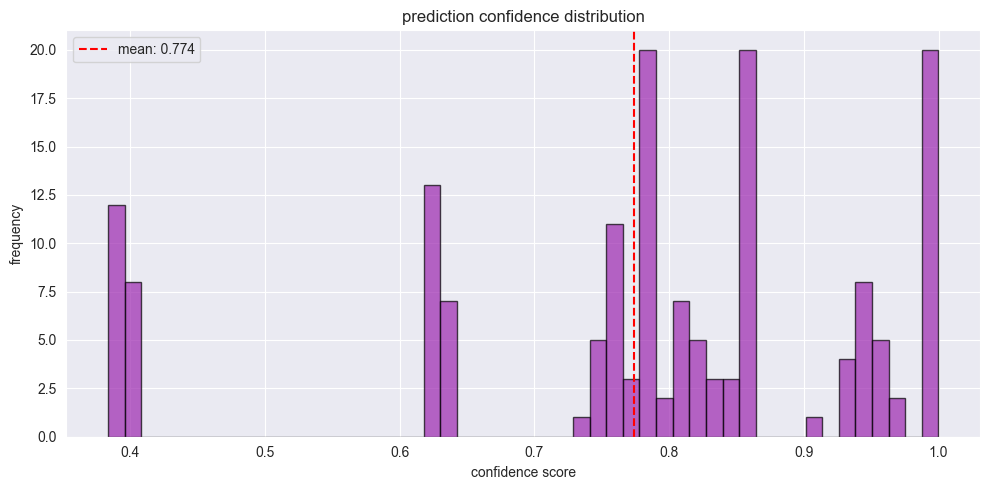

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(confidence_scores, bins=50, color='#9c27b0', alpha=0.7, edgecolor='black')
plt.xlabel('confidence score')
plt.ylabel('frequency')
plt.title('prediction confidence distribution')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', label=f'mean: {confidence_scores.mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
correct_mask = predicted_classes == test_labels
correct_confidence = confidence_scores[correct_mask]
incorrect_confidence = confidence_scores[~correct_mask]

print(f'correct predictions: {len(correct_confidence)} (avg confidence: {correct_confidence.mean():.4f})')
print(f'incorrect predictions: {len(incorrect_confidence)} (avg confidence: {incorrect_confidence.mean():.4f})')

correct predictions: 120 (avg confidence: 0.8396)
incorrect predictions: 40 (avg confidence: 0.5767)


## Sample Predictions

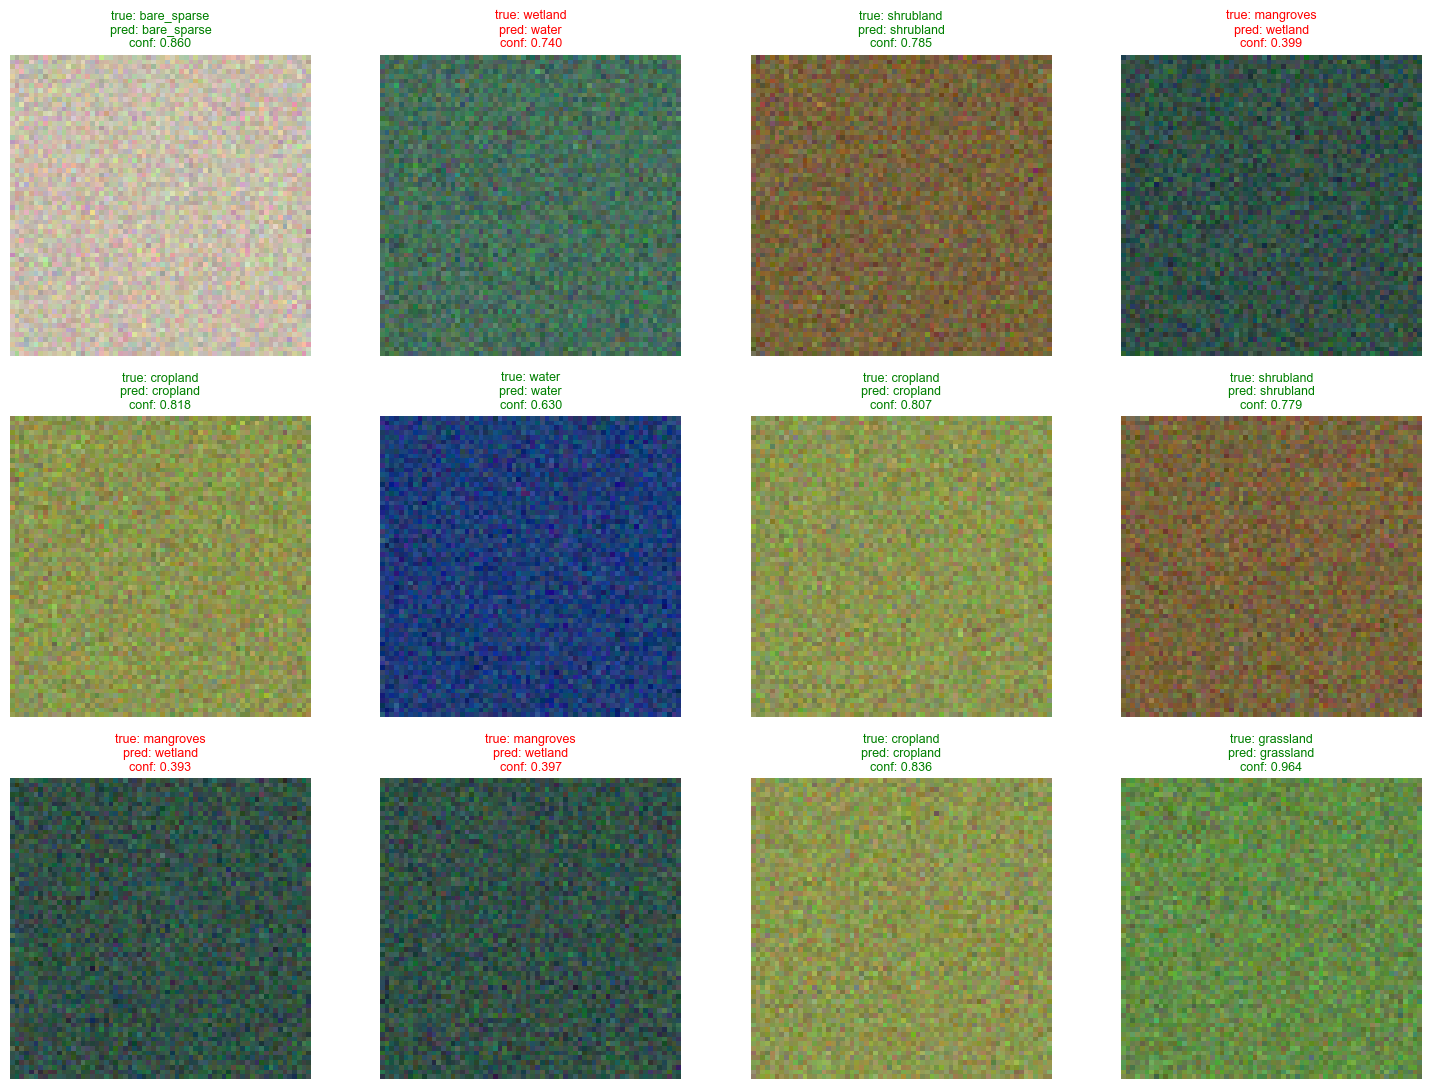

In [25]:
sample_indices = np.random.choice(len(test_images), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(15, 11))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    ax = axes[idx]
    ax.imshow(test_images[sample_idx])
    
    true_class = class_names[test_labels[sample_idx]]
    pred_class = class_names[predicted_classes[sample_idx]]
    conf = confidence_scores[sample_idx]
    
    is_correct = test_labels[sample_idx] == predicted_classes[sample_idx]
    color = 'green' if is_correct else 'red'
    
    ax.set_title(f'true: {true_class}\npred: {pred_class}\nconf: {conf:.3f}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Error Analysis

In [26]:
misclassified_indices = np.where(predicted_classes != test_labels)[0]
print(f'total misclassifications: {len(misclassified_indices)}')

if len(misclassified_indices) > 0:
    error_pairs = {}
    for idx in misclassified_indices:
        true_class = class_names[test_labels[idx]]
        pred_class = class_names[predicted_classes[idx]]
        pair = f'{true_class} -> {pred_class}'
        error_pairs[pair] = error_pairs.get(pair, 0) + 1
    
    sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)
    print('\nmost common misclassifications:')
    for pair, count in sorted_errors[:10]:
        print(f'{pair:30} {count:3} times')

total misclassifications: 40

most common misclassifications:
mangroves -> wetland            20 times
wetland -> water                20 times


## Model Summary

In [27]:
total_params = model.count_params()
print(f'total parameters: {total_params:,}')
print(f'input shape: {model.input_shape}')
print(f'output shape: {model.output_shape}')
print(f'number of layers: {len(model.layers)}')

total parameters: 2,420,393
input shape: (None, 64, 64, 3)
output shape: (None, 9)
number of layers: 22
